In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
import numpy as np
import matplotlib.pyplot as plt
from qutip import Qobj, sigmax, sigmaz, tensor, destroy, qeye, basis, fidelity
from scipy.optimize import minimize
from matplotlib.ticker import MaxNLocator
import qutip as qp

In [2]:
x_min = 100
x_max = 500
inv_vals = np.linspace(1/x_max, 1/x_min, 10)
x_vals = np.round(1 / inv_vals).astype(int)
x_vals = x_vals[::-1]
x_vals[0] = x_max
x_vals[-1] = x_min
steps_list = np.unique(x_vals)

In [3]:
# Define parameters
omega_0 = 1  # cavity frequency (ω_0)
Omega = 1  # qubit frequency (Ω)
lambda_val = 0.2
tru = 50  # Hilbert space dimension for cavity mode
T = 1
shots=10000

In [4]:
# Cavity mode operator
a = tensor(destroy(tru), qeye(2))

# atom operators
sz = tensor(qeye(tru), sigmaz()) 
sx = tensor(qeye(tru), sigmax())  

# The Rabi model Hamiltonian
H1 = omega_0 * a.dag() * a  
H2 = (Omega / 2) * sz  
H3 = lambda_val * (a.dag() + a) * sx  
H = H1 + H2 + H3  

In [5]:
op=H

fidelities_origin = []
eigenvalues_1, _ = np.linalg.eig(H1)
eigenvalues_2, _ = np.linalg.eig(H2)
eigenvalues_3, _ = np.linalg.eig(H3)

c1 = max(eigenvalues_1)
c2 = max(eigenvalues_2)
c3 = max(eigenvalues_3)

k = c1 + c2 + c3
    
# Probabilities for random selection
p1 = c1 / k
p2 = c2 / k
p3 = c3 / k
ps=[p1,p2,p3]

# Normalized Hamiltonians
H1_norm = H1 / c1
H2_norm = H2 / c2
H3_norm = H3 / c3
Hs=[H1_norm,H2_norm,H3_norm]
    
    
#initial_state=tensor(basis(tru,5), basis(2, 0))
initial_state=(tensor(basis(tru,5), basis(2, 0))+tensor(basis(tru,2), basis(2, 0)))/np.sqrt(2)

for s in range(10):
    steps = steps_list[s]
    tau=T/steps
    rho = initial_state*initial_state.dag() 
    exact_state=initial_state
    for j in range(steps):
        exact_state = (-1j * H * tau).expm()*exact_state # evolution of exact statae
        # evolution of random state in channel formula 
        rhos=[]
        for i in range(3):
            rhos.append(ps[i]*(-1j * Hs[i] * tau*k).expm() * rho * (1j * Hs[i] * tau*k).expm())
        rho=sum(rhos)
    rho_exact = exact_state*exact_state.dag()
    fidelity_origin = fidelity(rho,rho_exact)
    fidelities_origin.append(fidelity_origin)

In [6]:
op=H

fidelities_ew = []
c1 = 0.1
c2 = 0.1
c3 = 0.1

k = c1 + c2 + c3
    
# Probabilities for random selection
p1 = c1 / k
p2 = c2 / k
p3 = c3 / k
ps=[p1,p2,p3]

# Normalized Hamiltonians
H1_norm = H1 / c1
H2_norm = H2 / c2
H3_norm = H3 / c3
Hs=[H1_norm,H2_norm,H3_norm]
    
    
#initial_state=tensor(basis(tru,5), basis(2, 0))
initial_state=(tensor(basis(tru,5), basis(2, 0))+tensor(basis(tru,2), basis(2, 0)))/np.sqrt(2)
rho = initial_state*initial_state.dag() 
exact_state=initial_state
    
for s in range(10):
    steps = steps_list[s]
    tau=T/steps
    rho = initial_state*initial_state.dag() 
    exact_state=initial_state
    for j in range(steps):
        exact_state = (-1j * H * tau).expm()*exact_state # evolution of exact statae
        # evolution of random state in channel formula 
        rhos=[]
        for i in range(3):
            rhos.append(ps[i]*(-1j * Hs[i] * tau*k).expm() * rho * (1j * Hs[i] * tau*k).expm())
        rho=sum(rhos)
    rho_exact = exact_state*exact_state.dag()
    fidelity_ew = fidelity(rho,rho_exact)
    fidelities_ew.append(fidelity_ew)

In [7]:
terms=[]
terms.append(H1)
terms.append(H2)
terms.append(H3)

In [8]:
def D_ij(H_i, H_j, rho):
    a = 1j * (H_j * rho - rho * H_j)
    b = 1j * (H_i * a - a * H_i)
    return b

In [9]:
dt = 0.001

In [10]:
def D(H, rho, error_list):
    T1 = qp.expect(H,rho) + error_list[0]
    T2 = qp.expect(H * H,rho) + error_list[1]
    result = np.sqrt(abs(2*T2 - 2*T1**2))
    return result

In [11]:
def Fidelity(T, shots):
    
    Fidelity_list = []
    
    initial_state=(tensor(basis(tru,5), basis(2, 0))+tensor(basis(tru,2), basis(2, 0)))/np.sqrt(2)
    rho_initial = initial_state*initial_state.dag() 
    
    rho_list = 21 * [0]
    
    for s in range(10):
        steps = steps_list[s]
        print(s)
        exact_state=initial_state
        tau=T/steps
        for i in range(shots):
            rho = rho_initial
            for j in range(steps):
                a = [0] * 2
                b = [0] * 2
                c = [0] * 2
                for k in range(2):
                    a[k] = np.random.normal(loc=0, scale=0.1)
                    b[k] = np.random.normal(loc=0, scale=0.1)
                    c[k] = np.random.normal(loc=0, scale=0.1)
            
                D11 = D(terms[0], rho, a)
                D22 = D(terms[1], rho, b)
                D33 = D(terms[2], rho, c)
            
                Dsum=D11+D22+D33
                p1=D11/Dsum
                p2=D22/Dsum
                p3=D33/Dsum
                ps = [p1,p2,p3]
                
                rand= np.random.rand()
                if rand < ps[0]:
                    rho = (-1j * H1 * tau/p1).expm() * rho * (1j * H1 * tau/p1).expm()
                elif rand < ps[0] + ps[1]:
                    rho = (-1j * H2 * tau/p2).expm() * rho * (1j * H2 * tau/p2).expm()
                else:
                    rho = (-1j * H3 * tau/p3).expm() * rho * (1j * H3 * tau/p3).expm()
            rho_list[s] += rho / shots

                
         
        for i in range(steps):
            exact_state = (-1j * H * tau).expm()*exact_state
        rho_exact = exact_state*exact_state.dag()
        Fidelity = fidelity(rho_list[s],rho_exact)
        Fidelity_list.append(Fidelity)
    
    return Fidelity_list

In [12]:
Fidelity_list = Fidelity(T, shots)

0
1
2
3
4
5
6
7
8
9


In [13]:
tau_list=[T/steps for steps in steps_list]

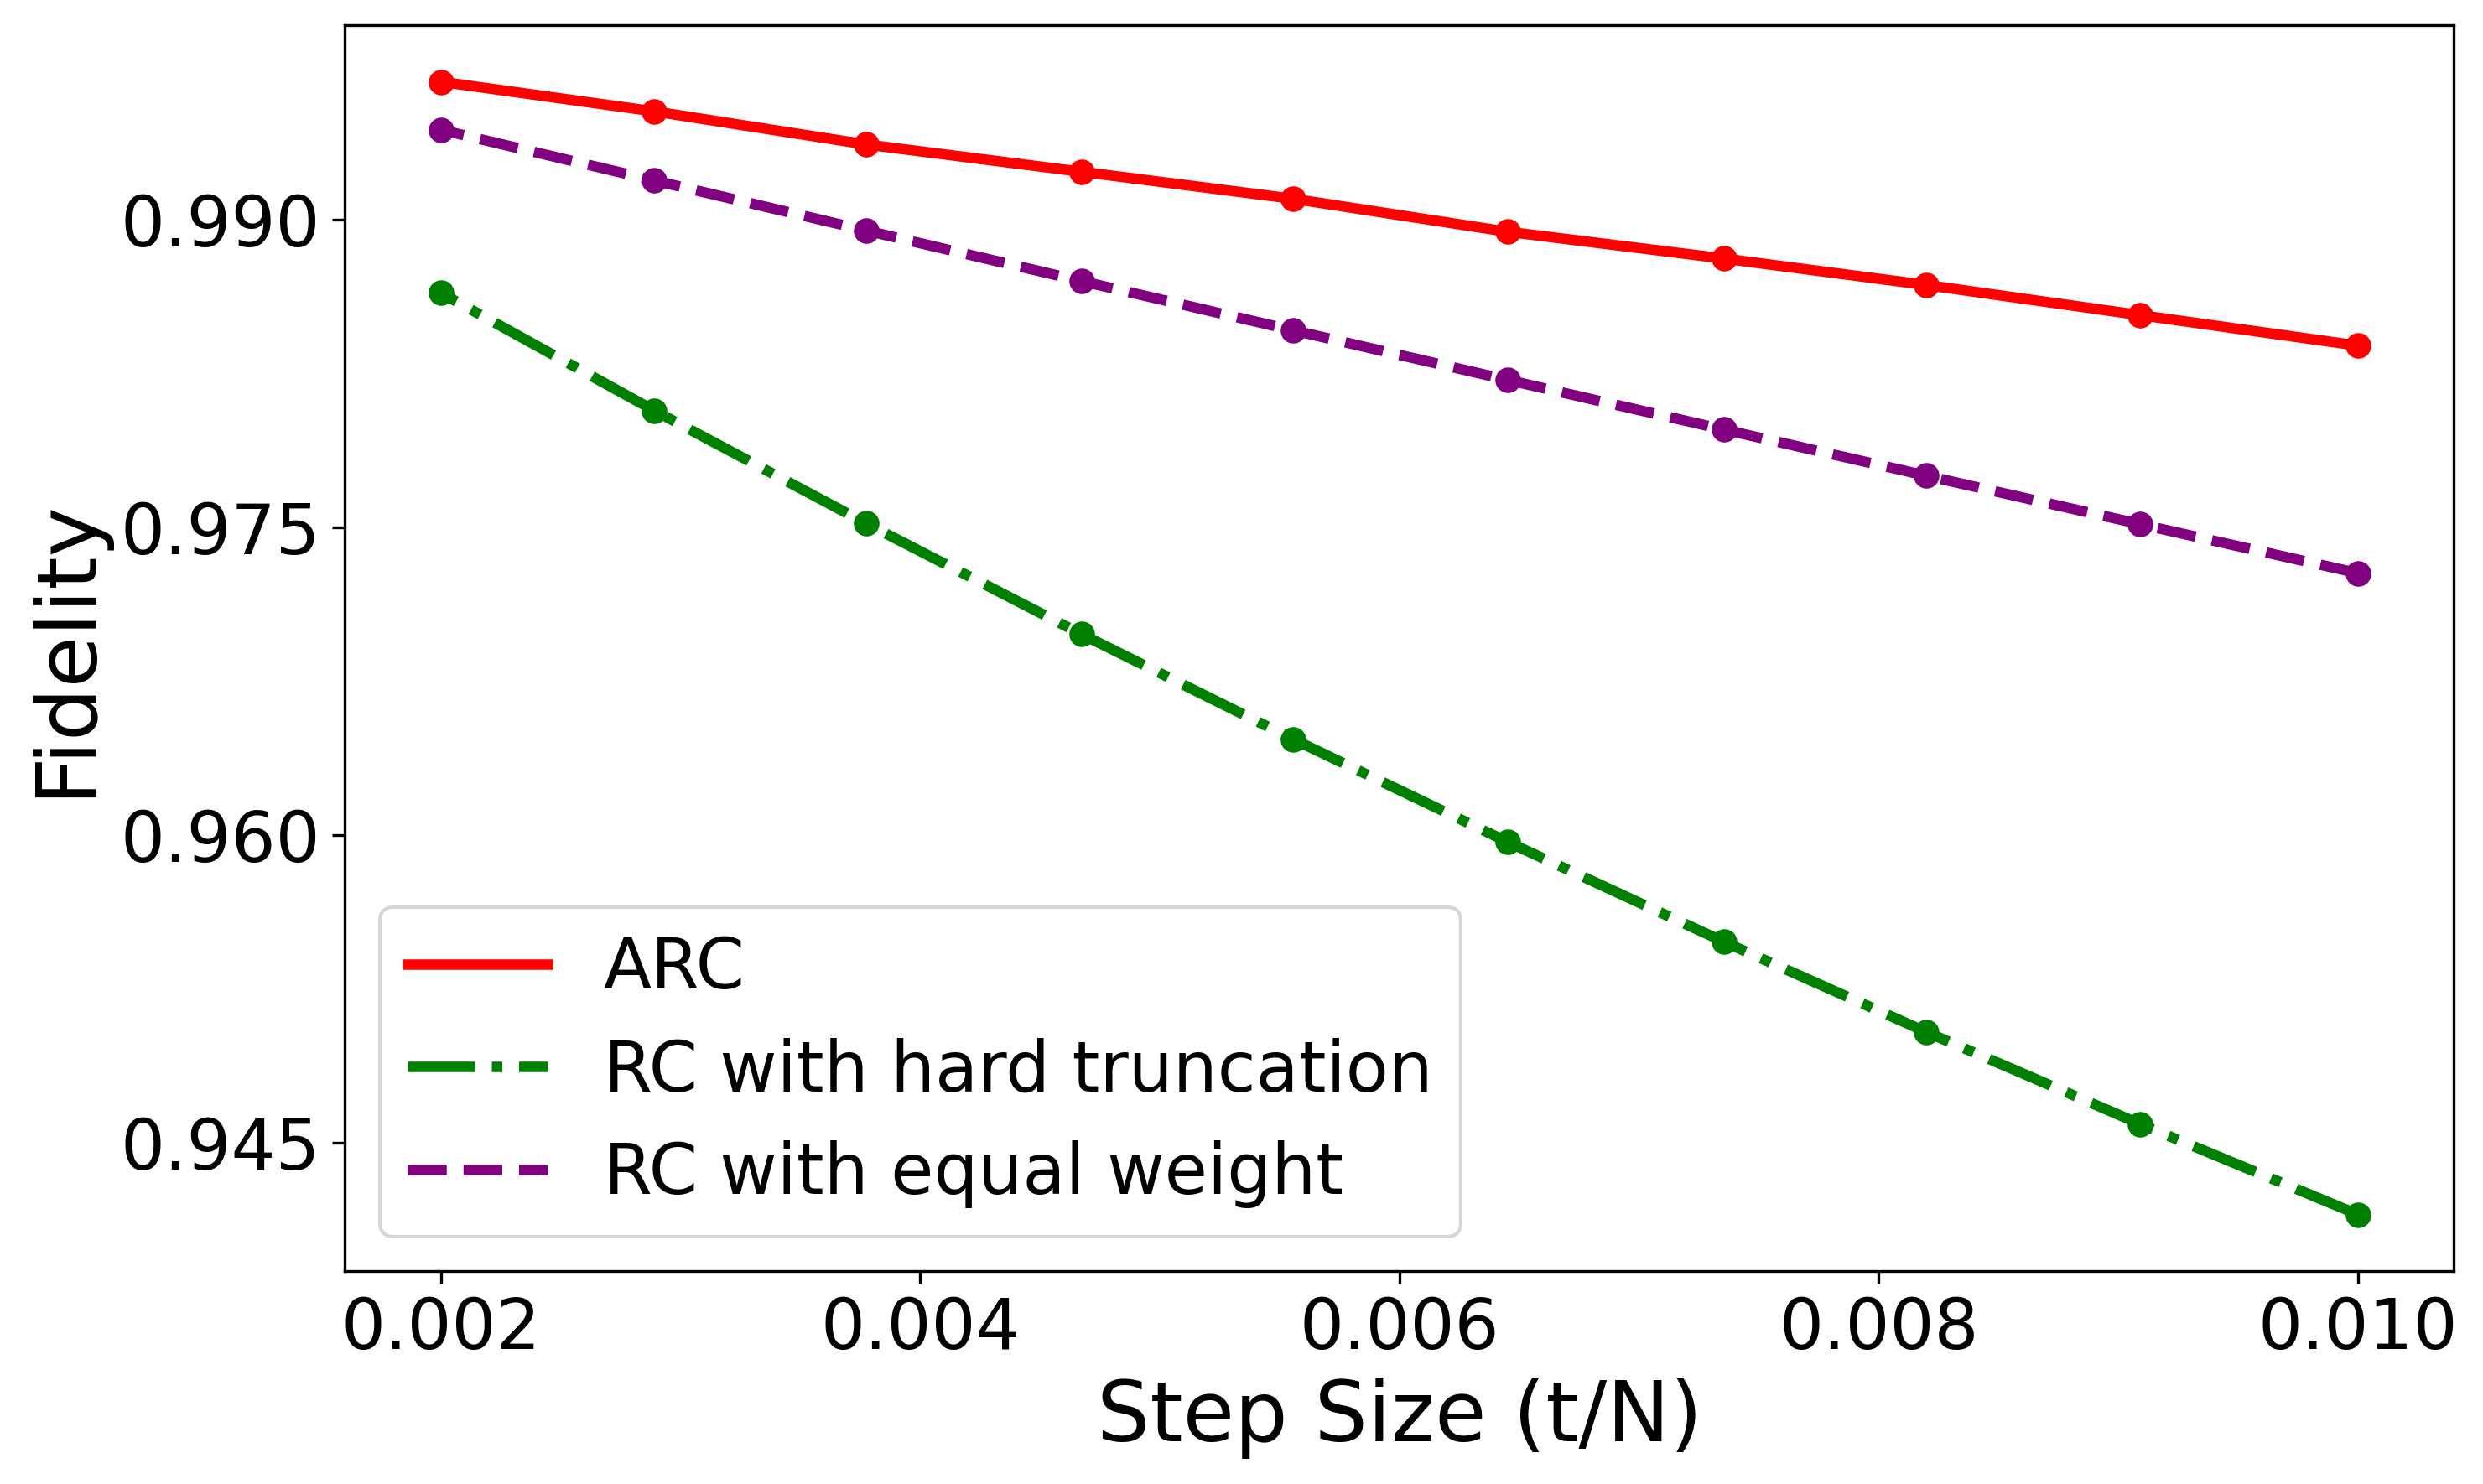

In [14]:
plt.figure(figsize=(10, 6), dpi=300)
    # Plot Fidelity for this beta value
plt.plot(tau_list, Fidelity_list, label=f'ARC', color='red', linewidth=3)
plt.plot(tau_list, fidelities_origin, label=f'RC with hard truncation', color='green', linestyle='-.', linewidth=3)
plt.plot(tau_list, fidelities_ew, label=f'RC with equal weight', color='purple', linestyle='--', linewidth=3)

plt.scatter(tau_list, Fidelity_list, color='red', s=40)
plt.scatter(tau_list, fidelities_origin, color='green', s=40)
plt.scatter(tau_list, fidelities_ew, color='purple', s=40)

plt.xlabel("Step Size (t/N)", fontsize=24)
plt.ylabel("Fidelity", fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

ax = plt.gca()  # 获取当前坐标轴
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
ax.xaxis.set_major_locator(MaxNLocator(nbins=5))
plt.tight_layout()
plt.show()

In [15]:
print(Fidelity_list)

[0.983865790833998, 0.9853513686207109, 0.9868235253155566, 0.9881102744721523, 0.9894143227085677, 0.9910244663612688, 0.9923386726219052, 0.9936720913160921, 0.9952834803549603, 0.996725140689786]


In [16]:
print(fidelities_origin)

[0.9415150928123817, 0.9459244744050377, 0.9504210693697255, 0.954813795249335, 0.9596754560667763, 0.9646872468496388, 0.9698043752707197, 0.975206395517073, 0.9807016527776653, 0.9864304258476955]


In [17]:
print(fidelities_ew)

[0.9727738876355602, 0.9751632236633093, 0.9775295884857715, 0.9797769302942243, 0.9821938499298051, 0.9846141113924987, 0.9870140988365274, 0.9894787248986271, 0.9919155338969743, 0.9943873126219209]


In [21]:
ARC=[0.983757225202715, 0.9850685488335156, 0.9865071786855547, 0.9879072015418636, 0.9893518542265467, 0.9907719929879415, 0.9922496908558258, 0.9938254785049219, 0.9952112087390799, 0.9967020587145455]

In [19]:
def add_extended_fit_line_1(x, y, color, linestyle, label):
    # 找最靠近0的两个点
    sorted_indices = np.argsort(x)
    idx1, idx2 = sorted_indices[0], sorted_indices[1]

    x_points = np.array([x[idx1], x[idx2]])
    y_points = np.array([y[idx1], y[idx2]])

    slope = (y_points[1] - y_points[0]) / (x_points[1] - x_points[0])
    intercept = y_points[0] - slope * x_points[0]

    x_fit = np.linspace(0, x_points[0], 200)
    y_fit = slope * x_fit + intercept

    plt.plot(x_fit, y_fit, color=color, linestyle=linestyle, linewidth=2, label=label)

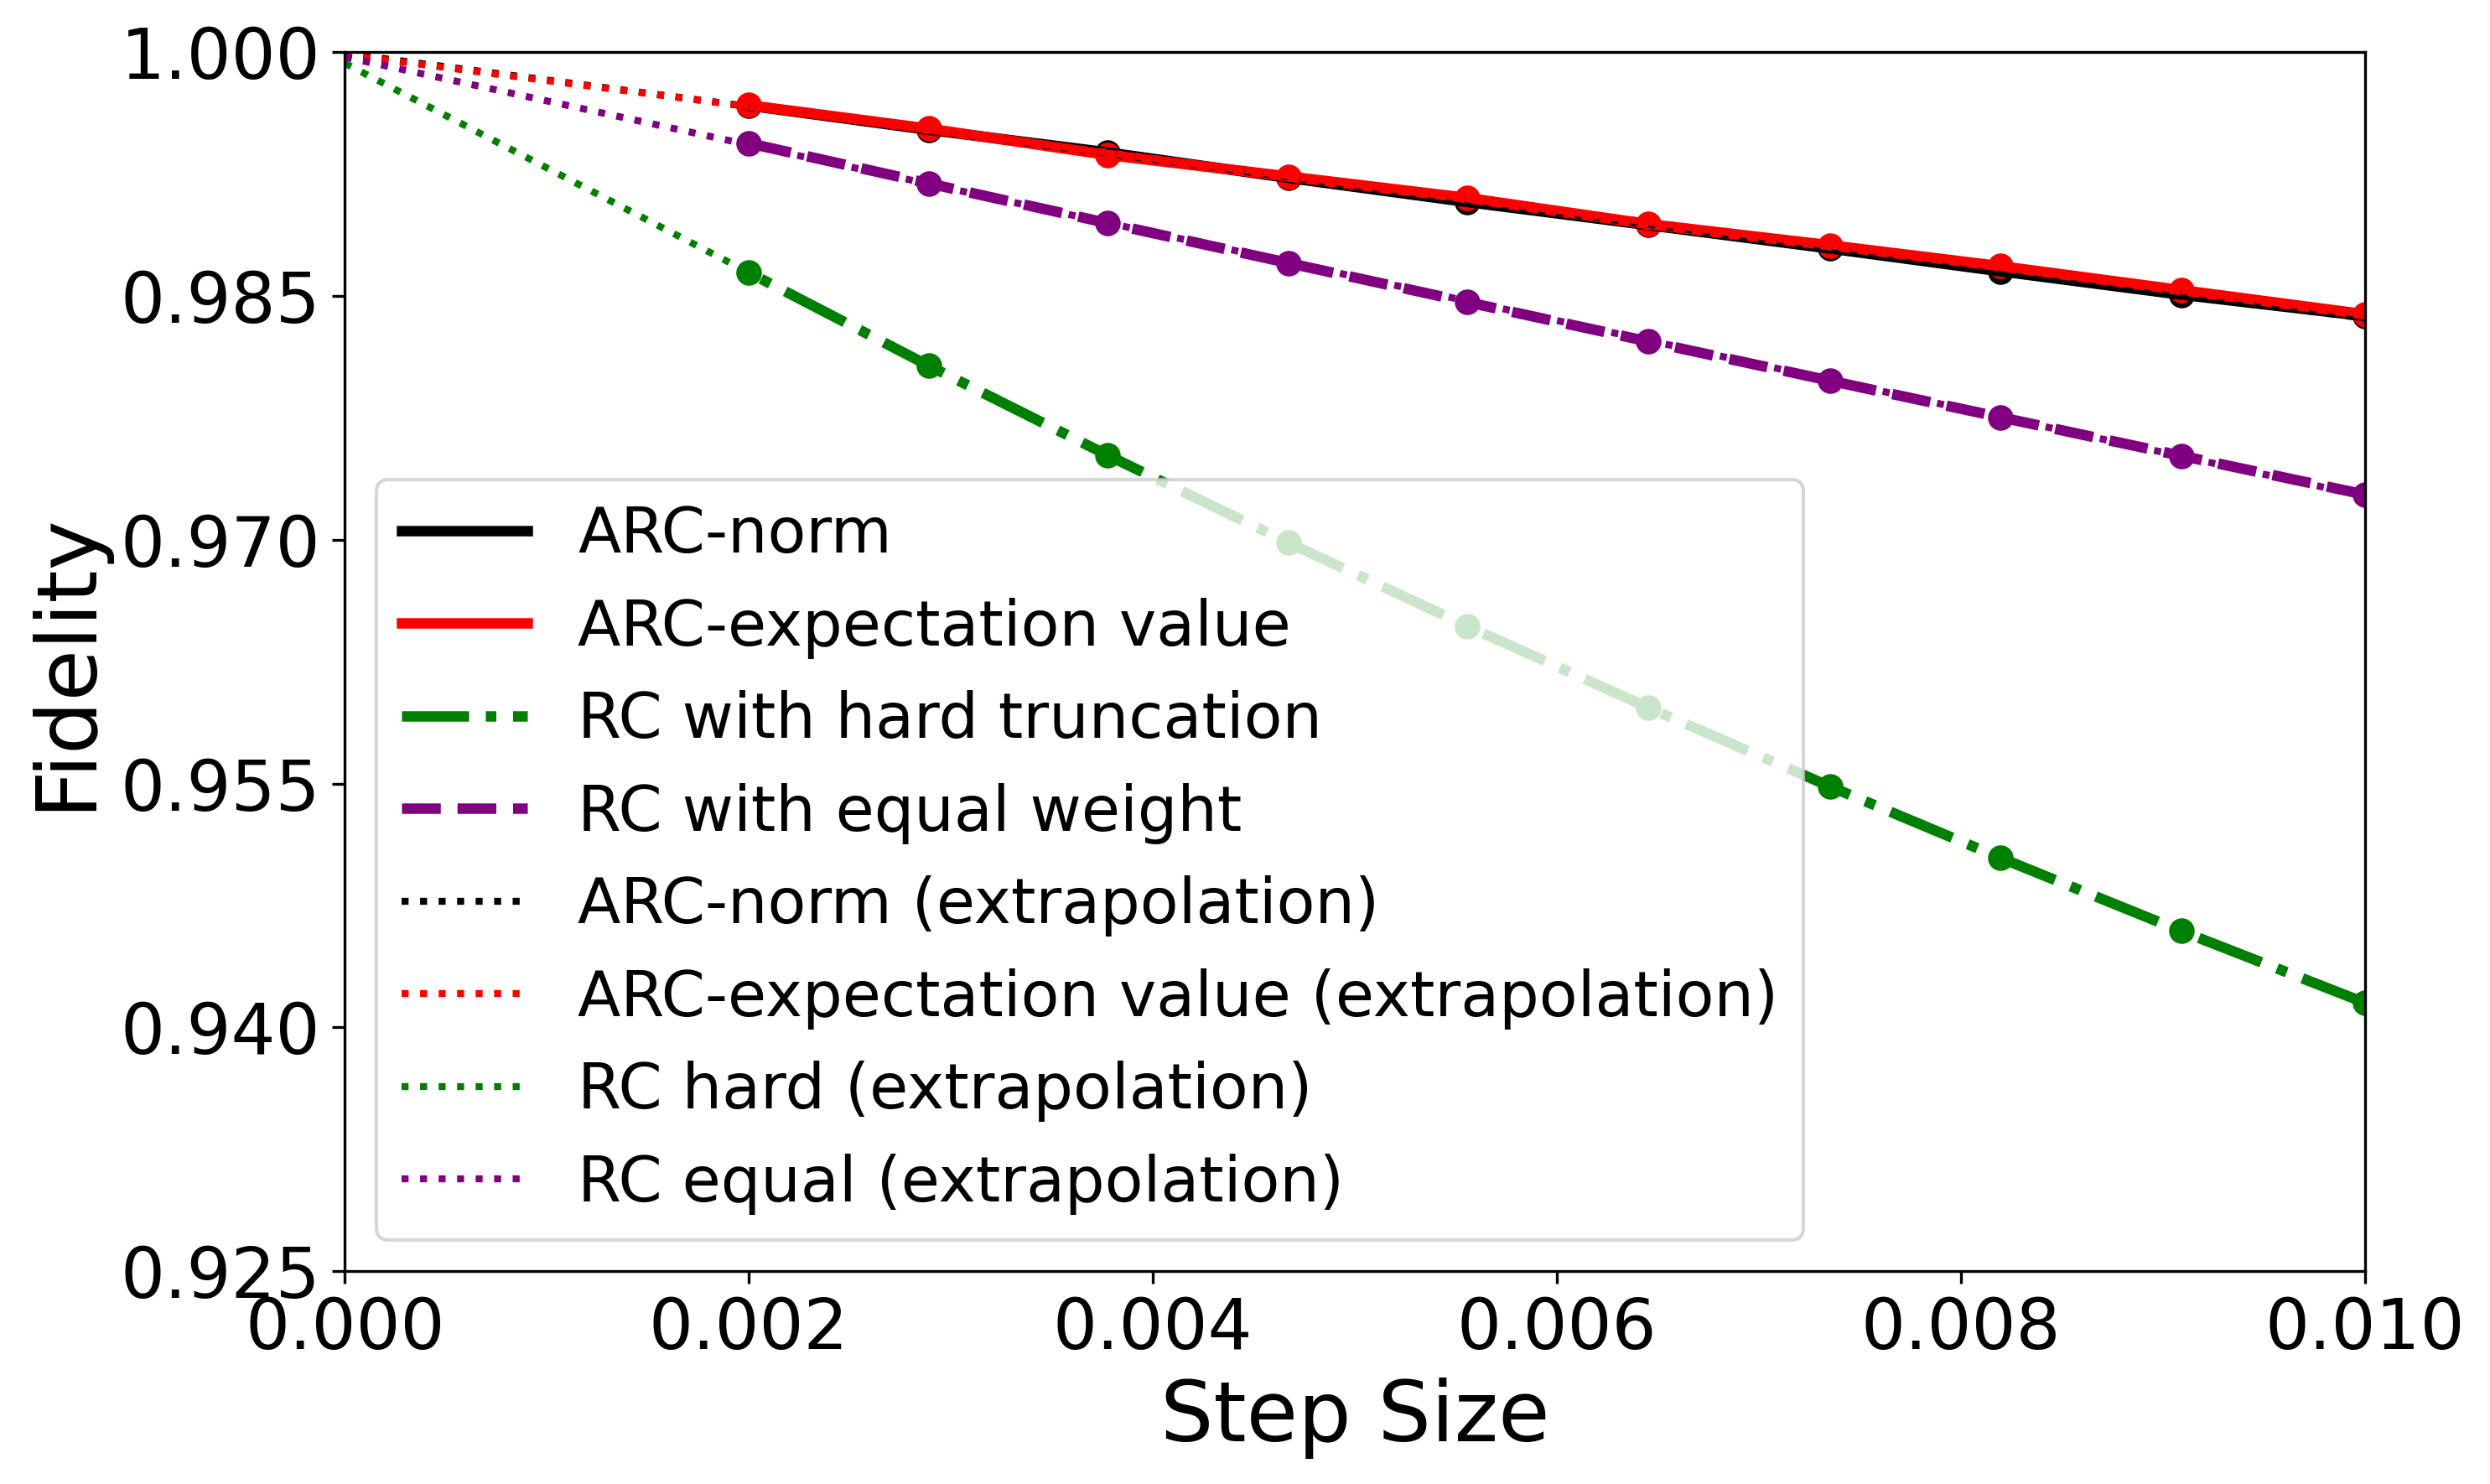

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def add_extended_fit_line(x, y, color, linestyle, label):
    slope, intercept = np.polyfit(x, y, deg=1)
    x_fit = np.linspace(0, max(x), 200)
    y_fit = slope * x_fit + intercept
    plt.plot(x_fit, y_fit, color=color, linestyle=linestyle, linewidth=2, label=label)

plt.figure(figsize=(10, 6), dpi=300)

# 画三条原始曲线
plt.plot(tau_list, ARC, label='ARC', color='black', linewidth=3)
plt.plot(tau_list, Fidelity_list, label='FARC', color='red', linewidth=3)
plt.plot(tau_list, fidelities_origin, label='RC with hard truncation', color='green', linestyle='-.', linewidth=3)
plt.plot(tau_list, fidelities_ew, label='RC with equal weight', color='purple', linestyle='--', linewidth=3)

plt.scatter(tau_list, ARC, color='black', s=40)
plt.scatter(tau_list, Fidelity_list, color='red', s=40)
plt.scatter(tau_list, fidelities_origin, color='green', s=40)
plt.scatter(tau_list, fidelities_ew, color='purple', s=40)

# 画三条回归延长线，从x=0开始，虚线
add_extended_fit_line(tau_list, ARC, 'black', ':', 'ARC (extrapolation)')
add_extended_fit_line(tau_list, Fidelity_list, 'red', ':', 'FARC (extrapolation)')
add_extended_fit_line_1(tau_list, fidelities_origin, 'green', ':', 'RC hard (extrapolation)')
add_extended_fit_line(tau_list, fidelities_ew, 'purple', ':', 'RC equal (extrapolation)')

# 设置坐标轴范围
plt.xlim(0, max(tau_list))
plt.ylim(0.94, 1)  # 纵坐标范围设为 [0.925, 1]

ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(nbins=6))

# 手动设置纵坐标刻度，从1递减，每步0.015，6个点
yticks = np.linspace(1, 1 - 0.015 * 5, 6)  # 1 - 0.015*5 是第6个点
ax.set_yticks(yticks)

plt.xlabel("Step Size", fontsize=24)
plt.ylabel("Fidelity", fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.legend(fontsize=18)
plt.tight_layout()
plt.show()